In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime as dt
from scipy import stats
from scipy.stats import norm, skew

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split,GridSearchCV

## Load Data

In [2]:
df_cust_info = pd.read_csv("../dataset/TBN_CIF.csv",encoding = "utf8") 
df_cust_behavior = pd.read_csv("../dataset/TBN_CUST_BEHAVIOR.csv",encoding = "utf8") 
df_cust_CC = pd.read_csv("../dataset/TBN_CC_APPLY.csv",encoding = "utf8")  #信用卡 權重 X 10
df_cust_FX = pd.read_csv("../dataset/TBN_FX_TXN.csv",encoding = "utf8")    #外匯 權重 X 1
df_cust_LN = pd.read_csv("../dataset/TBN_LN_APPLY.csv",encoding = "utf8")  #信貸 權重 X 20
df_cust_WM = pd.read_csv("../dataset/TBN_WM_TXN.csv",encoding = "utf8")    #信託 權重 X 20
df_cust_recent_dt = pd.read_csv("../dataset/TBN_RECENT_DT.csv",encoding = "utf8") 
df_submit = pd.read_csv("../dataset/TBN_Y_ZERO.csv",encoding = "utf8") 

## Customer Data

In [3]:
df_cust_info=df_cust_info.fillna(999)

In [4]:
df_cust_info['AGE']=df_cust_info['AGE'].astype('category')
df_cust_info['GENDER_CODE']=df_cust_info['GENDER_CODE'].astype('category')
df_cust_info['CHILDREN_CNT']=df_cust_info['CHILDREN_CNT'].astype('category')
df_cust_info['EDU_CODE']=df_cust_info['EDU_CODE'].astype('category')
df_cust_info['INCOME_RANGE_CODE']=df_cust_info['INCOME_RANGE_CODE'].astype('category')
df_cust_info['WORK_MTHS']=df_cust_info['WORK_MTHS'].astype('category')

In [5]:
df_cust_info_ohe = pd.get_dummies(df_cust_info[['GENDER_CODE','AGE','CHILDREN_CNT','EDU_CODE','INCOME_RANGE_CODE','WORK_MTHS']])

In [6]:
df_cust_info=pd.concat([df_cust_info, df_cust_info_ohe], axis=1)

In [7]:
df_cust_no=df_cust_info[['CUST_NO']].copy()

In [8]:
df_cust_info['CUST_YEAR'] = df_cust_info.CUST_START_DT/365 
df_cust_info['CUST_YEAR'] = np.where(df_cust_info['CUST_YEAR']<0.002,0.00274,df_cust_info['CUST_YEAR'])

In [9]:
df_cust_info.CUST_START_DT.describe(),df_cust_info.CUST_YEAR.describe()

(count    187679.000000
 mean       6260.023998
 std        2385.903856
 min           0.000000
 25%        4296.000000
 50%        6747.000000
 75%        8367.000000
 max        9567.000000
 Name: CUST_START_DT, dtype: float64, count    187679.000000
 mean         17.150751
 std           6.536721
 min           0.002740
 25%          11.769863
 50%          18.484932
 75%          22.923288
 max          26.210959
 Name: CUST_YEAR, dtype: float64)

In [10]:
df_cust_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187679 entries, 0 to 187678
Data columns (total 44 columns):
CUST_NO                    187679 non-null object
AGE                        187679 non-null category
CHILDREN_CNT               187679 non-null category
CUST_START_DT              187679 non-null float64
EDU_CODE                   187679 non-null category
GENDER_CODE                187679 non-null category
INCOME_RANGE_CODE          187679 non-null category
WORK_MTHS                  187679 non-null category
GENDER_CODE_999            187679 non-null uint8
GENDER_CODE_F              187679 non-null uint8
GENDER_CODE_M              187679 non-null uint8
AGE_1                      187679 non-null uint8
AGE_2                      187679 non-null uint8
AGE_3                      187679 non-null uint8
AGE_4                      187679 non-null uint8
CHILDREN_CNT_0.0           187679 non-null uint8
CHILDREN_CNT_1.0           187679 non-null uint8
CHILDREN_CNT_2.0           187679 n

## Browse URL

In [11]:
df_cust_behavior_train=df_cust_behavior[df_cust_behavior.VISITDATE<9538].copy()
df_cust_behavior_test =df_cust_behavior[df_cust_behavior.VISITDATE>=9478].copy()

In [12]:
df_cust_behavior_train['PAGE1']=df_cust_behavior_train['PAGE'].apply(lambda x: x.replace("http://www.esunbank.com.tw/", ""))
df_cust_behavior_train['PAGE1']=df_cust_behavior_train['PAGE1'].apply(lambda x: x.replace("https://www.esunbank.com.tw/", "")) 
df_cust_behavior_train['PAGE1']=df_cust_behavior_train['PAGE1'].apply(lambda x: x[0:21])

df_cust_behavior_train['PAGE1']=df_cust_behavior_train['PAGE1'].astype('category') 
df_cust_behavior_train['PAGE_CAT']=df_cust_behavior_train['PAGE1'].cat.codes

df_cust_behavior_train['PAGE_OFTEN_CAT']=np.where(df_cust_behavior_train['PAGE_CAT'].isin([25,23,21,19,135,257,3,192,155,9,261,177,69,11,35,252,259,5,196,223,14,210]),df_cust_behavior_train.PAGE_CAT,999)
df_cust_behavior_train['PAGE_OFTEN_CAT']=df_cust_behavior_train['PAGE_OFTEN_CAT'].astype('category') 
df_cust_behavior_train_ohe = pd.get_dummies(df_cust_behavior_train[['PAGE_OFTEN_CAT']])

df_cust_behavior_train=pd.concat([df_cust_behavior_train, df_cust_behavior_train_ohe], axis=1)

In [13]:
df_cust_page=df_cust_behavior_train[['PAGE','PAGE_OFTEN_CAT']].drop_duplicates()
df_cust_behavior_test=pd.merge(left=df_cust_behavior_test, right=df_cust_page, on=["PAGE"], how="left")

In [14]:
df_cust_behavior_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1449418 entries, 0 to 1449417
Data columns (total 4 columns):
CUST_NO           1449418 non-null object
VISITDATE         1449418 non-null int64
PAGE              1449418 non-null object
PAGE_OFTEN_CAT    1446561 non-null category
dtypes: category(1), int64(1), object(2)
memory usage: 45.6+ MB


In [15]:
df_cust_behavior_test_ohe = pd.get_dummies(df_cust_behavior_test[['PAGE_OFTEN_CAT']])
df_cust_behavior_test=pd.concat([df_cust_behavior_test, df_cust_behavior_test_ohe], axis=1)

In [16]:
df_cust_behavior_sum=df_cust_behavior_train.groupby('CUST_NO').agg({'PAGE':['count','nunique'],'VISITDATE':['max','min']})
df_cust_behavior_sum.columns=['BROWSE_CNT','BROWSE_URL','BROWSE_DATE_MAX','BROWSE_DATE_MIN']
df_cust_behavior_sum['CUST_NO']=df_cust_behavior_sum.index

In [17]:
df_cust_behavior_test_sum=df_cust_behavior_test.groupby('CUST_NO').agg({'PAGE':['count','nunique'],'VISITDATE':['max','min']})
df_cust_behavior_test_sum.columns=['BROWSE_CNT','BROWSE_URL','BROWSE_DATE_MAX','BROWSE_DATE_MIN']
df_cust_behavior_test_sum['CUST_NO']=df_cust_behavior_test_sum.index

In [18]:
df_cust_behavior_1=df_cust_behavior_train.copy()
df_cust_behavior_1=df_cust_behavior_1.drop(['VISITDATE','PAGE','PAGE1','PAGE_CAT'], axis=1) #'PAGE_CAT' 'PAGE_OFTEN_CAT'
df_cust_behavior_1_sum=df_cust_behavior_1.groupby('CUST_NO').sum()

In [19]:
df_cust_behavior_test_1=df_cust_behavior_test.copy()
df_cust_behavior_test_1=df_cust_behavior_test_1.drop(['VISITDATE','PAGE'], axis=1)  # PAGE_OFTEN_CAT
df_cust_behavior_test_1_sum=df_cust_behavior_test_1.groupby('CUST_NO').sum()

In [20]:
df_cust_train=pd.merge(left=df_cust_info, right=df_cust_behavior_sum, on=["CUST_NO"], how="left")
df_cust_train=pd.merge(left=df_cust_train, right=df_cust_behavior_1_sum, on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
df_cust_info_test=pd.merge(left=df_submit[['CUST_NO']], right=df_cust_info, on=["CUST_NO"], how="left")

In [22]:
df_cust_test=pd.merge(left=df_cust_info_test, right=df_cust_behavior_test_sum, on=["CUST_NO"], how="left") 

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [23]:
df_cust_test=pd.merge(left=df_cust_test, right=df_cust_behavior_test_1_sum, on=["CUST_NO"], how="left")

In [24]:
df_cust_train.info()#[['CUST_NO','BROWSE_CNT']][df_cust_test.CUST_NO=='QQ-5RC5UBNRYVKTM']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187679 entries, 0 to 187678
Data columns (total 71 columns):
CUST_NO                    187679 non-null object
AGE                        187679 non-null category
CHILDREN_CNT               187679 non-null category
CUST_START_DT              187679 non-null float64
EDU_CODE                   187679 non-null category
GENDER_CODE                187679 non-null category
INCOME_RANGE_CODE          187679 non-null category
WORK_MTHS                  187679 non-null category
GENDER_CODE_999            187679 non-null uint8
GENDER_CODE_F              187679 non-null uint8
GENDER_CODE_M              187679 non-null uint8
AGE_1                      187679 non-null uint8
AGE_2                      187679 non-null uint8
AGE_3                      187679 non-null uint8
AGE_4                      187679 non-null uint8
CHILDREN_CNT_0.0           187679 non-null uint8
CHILDREN_CNT_1.0           187679 non-null uint8
CHILDREN_CNT_2.0           187679 n

In [25]:
df_cust_test.BROWSE_DATE_MIN.describe()#, df_cust_test.BROWSE_DATE_FIRST_DAYS.describe()

count    30000.000000
mean      9529.197833
std         29.923104
min       9478.000000
25%       9500.000000
50%       9540.000000
75%       9554.000000
max       9567.000000
Name: BROWSE_DATE_MIN, dtype: float64

In [26]:
df_cust_train['BROWSE_DATE_LAST_DAYS']=9538-df_cust_train.BROWSE_DATE_MAX
df_cust_train['BROWSE_DATE_FIRST_DAYS']=9538-df_cust_train.BROWSE_DATE_MIN
df_cust_test['BROWSE_DATE_LAST_DAYS']=9568-df_cust_test.BROWSE_DATE_MAX
df_cust_test['BROWSE_DATE_FIRST_DAYS']=9568-df_cust_test.BROWSE_DATE_MIN

# Visualization

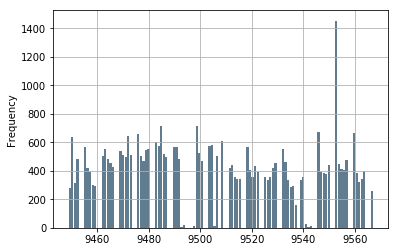

In [27]:
df_cust_WM.TXN_DT.plot.hist(grid=True, bins=120, rwidth=0.9,color='#607c8e')

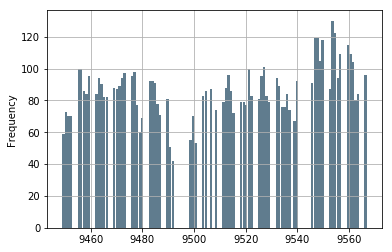

In [28]:
df_cust_LN.TXN_DT.plot.hist(grid=True, bins=120, rwidth=0.9,color='#607c8e') 

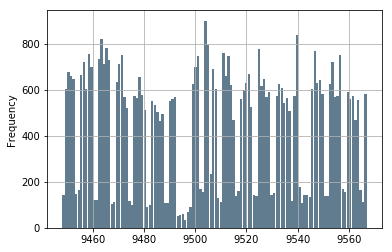

In [29]:
df_cust_CC.TXN_DT.plot.hist(grid=True, bins=120, rwidth=0.9,color='#607c8e')

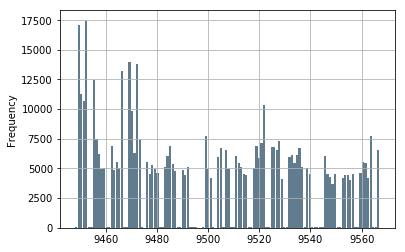

In [30]:
df_cust_FX.TXN_DT.plot.hist(grid=True, bins=120, rwidth=0.9,color='#607c8e')

## WM Data

In [31]:
df_cust_WM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36763 entries, 0 to 36762
Data columns (total 5 columns):
CUST_NO             36763 non-null object
TXN_DT              36763 non-null int64
CUST_RISK_CODE      36676 non-null float64
INVEST_TYPE_CODE    36763 non-null int64
WM_TXN_AMT          36763 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 1.4+ MB


In [32]:
df_WM_D0=df_cust_recent_dt[df_cust_recent_dt.WM_RECENT_DT.notnull()].groupby('CUST_NO').agg({'WM_RECENT_DT':'max'})
df_WM_D0.columns=['D0_WM_DATE_MAX']
df_WM_D0['CUST_NO']=df_WM_D0.index
df_WM=pd.merge(left=df_cust_no, right=df_WM_D0, on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:
 #df_WM_D0[df_WM_D0.D0_WM_CNT!=1].head()

In [34]:
df_cust_WM_D90=df_cust_WM[df_cust_WM.TXN_DT>=9448][df_cust_WM.TXN_DT<9538]
df_cust_WM_N30=df_cust_WM[df_cust_WM.TXN_DT>=9538][df_cust_WM.TXN_DT<9568]

C:\Users\Anson\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [35]:
df_WM_D90=df_cust_WM_D90.groupby('CUST_NO').agg({'CUST_NO':'count','TXN_DT':['max','min'],'WM_TXN_AMT':['sum','min','max','std','mean'],'CUST_RISK_CODE':'median','INVEST_TYPE_CODE':'median'})

In [36]:
df_WM_D90.columns=['D90_WM_CNT','D90_WM_DATE_MAX','D90_WM_DATE_MIN','D90_WM_AMT_SUM','D90_WM_AMT_MIN','D90_WM_AMT_MAX','D90_WM_AMT_STD','D90_WM_AMT_AVG','D90_WM_CUST_RISK_CODE','D90_WM_CUST_INVEST_TYPE_CODE']

In [37]:
df_WM_D90['CUST_NO']=df_WM_D90.index

In [38]:
df_WM_D90['WM_DAY_INTERVAL_LAST']=9538-df_WM_D90['D90_WM_DATE_MAX']
df_WM_D90['WM_DAY_INTERVAL_FIRST']=9538-df_WM_D90['D90_WM_DATE_MIN']
df_WM_D90['WM_DAY_INTERVAL_AVG']=(9538-df_WM_D90['D90_WM_DATE_MIN'])/df_WM_D90['D90_WM_CNT']

In [39]:
df_WM_D90.head()

,D90_WM_CNT,D90_WM_DATE_MAX,D90_WM_DATE_MIN,D90_WM_AMT_SUM,D90_WM_AMT_MIN,D90_WM_AMT_MAX,D90_WM_AMT_STD,D90_WM_AMT_AVG,D90_WM_CUST_RISK_CODE,D90_WM_CUST_INVEST_TYPE_CODE,CUST_NO,WM_DAY_INTERVAL_LAST,WM_DAY_INTERVAL_FIRST,WM_DAY_INTERVAL_AVG
CUST_NO,,,,,,,,,,,,,,
--0PHCW9D_3SAAFS,2,9477,9462,2003080,941590,1061490,84782.103064,1001540.0,3.0,1.0,--0PHCW9D_3SAAFS,61,76,38.00
--DLGTMNFWJYWXKG,4,9485,9479,2156010,439191,605885,81775.532826,539002.5,4.0,1.0,--DLGTMNFWJYWXKG,53,59,14.75
--NYXRPESVALBKQ8,2,9490,9466,1935788,505049,1430739,654561.676277,967894.0,4.0,2.0,--NYXRPESVALBKQ8,48,72,36.00
-0SRY4Q-CASJ2LHS,1,9532,9532,505049,505049,505049,NaN,505049.0,4.0,2.0,-0SRY4Q-CASJ2LHS,6,6,6.00
-0XO58X64I07YHSS,1,9511,9511,605885,605885,605885,NaN,605885.0,4.0,1.0,-0XO58X64I07YHSS,27,27,27.00


In [40]:
df_WM=pd.merge(left=df_WM, right=df_WM_D90, on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [41]:
df_WM_N30=df_cust_WM_N30.groupby('CUST_NO').agg({'CUST_NO':'count'})

In [42]:
df_WM_N30.columns=['N30_WM_CNT']

In [43]:
df_WM_N30['CUST_NO']=df_WM_N30.index

In [44]:
df_WM_N30['NEXT_WM_APPLY']=np.where(df_WM_N30.N30_WM_CNT.notnull(),1,0)

In [45]:
df_WM=pd.merge(left=df_WM, right=df_WM_N30[['CUST_NO','NEXT_WM_APPLY']], on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [46]:
df_train = pd.merge(left=df_cust_train, right=df_WM, on=["CUST_NO"], how="left")

## LN Data

In [47]:
df_LN_D0=df_cust_recent_dt[df_cust_recent_dt.LN_RECENT_DT.notnull()].groupby('CUST_NO').agg({'LN_RECENT_DT': 'max' })
df_LN_D0.columns=['D0_LN_DATE_MAX']
df_LN_D0['CUST_NO']=df_LN_D0.index
df_LN=pd.merge(left=df_cust_no, right=df_LN_D0, on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [48]:
df_cust_LN_D90=df_cust_LN[df_cust_LN.TXN_DT>=9448][df_cust_LN.TXN_DT<9538]
df_cust_LN_N30=df_cust_LN[df_cust_LN.TXN_DT>=9538][df_cust_LN.TXN_DT<9568]

C:\Users\Anson\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [49]:
df_LN_D90=df_cust_LN_D90.groupby('CUST_NO').agg({'CUST_NO':'count','TXN_DT':['max','min'],'LN_AMT':['sum','min','max','std','mean'],'LN_USE':'max'})
df_LN_D90.columns=['D90_LN_CNT','D90_LN_DATE_MAX','D90_LN_DATE_MIN','D90_LN_AMT_SUM','D90_LN_AMT_MIN','D90_LN_AMT_MAX','D90_LN_AMT_STD','D90_LN_AMT_AVG','LN_USE']
df_LN_D90['CUST_NO']=df_LN_D90.index 

In [50]:
df_LN_D90['LN_USE']=np.where(df_LN_D90['LN_USE']=='0Z',70,df_LN_D90['LN_USE'])
df_LN_D90[['LN_USE']]=df_LN_D90[['LN_USE']].astype(float)

In [51]:
df_LN_D90['LN_DAY_INTERVAL_LAST']=9538-df_LN_D90['D90_LN_DATE_MAX']
df_LN_D90['LN_DAY_INTERVAL_FIRST']=9538-df_LN_D90['D90_LN_DATE_MIN']
df_LN_D90['LN_DAY_INTERVAL_AVG']=(9538-df_LN_D90['D90_LN_DATE_MIN'])/df_LN_D90['D90_LN_CNT']

In [52]:
df_LN=pd.merge(left=df_LN, right=df_LN_D90, on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [53]:
df_LN_N30=df_cust_LN_N30.groupby('CUST_NO').agg({'CUST_NO':'count'})
df_LN_N30.columns=['N30_LN_CNT']
df_LN_N30['CUST_NO']=df_LN_N30.index
df_LN_N30['NEXT_LN_APPLY']=np.where(df_LN_N30.N30_LN_CNT.notnull(),1,0)
df_LN=pd.merge(left=df_LN, right=df_LN_N30[['CUST_NO','NEXT_LN_APPLY']], on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [54]:
CM_LN=[ 'D0_LN_DATE_MAX','D90_LN_CNT','D90_LN_DATE_MAX','D90_LN_DATE_MIN','D90_LN_AMT_SUM','D90_LN_AMT_MIN','D90_LN_AMT_MAX','D90_LN_AMT_STD','D90_LN_AMT_AVG','LN_USE','LN_DAY_INTERVAL_LAST','LN_DAY_INTERVAL_AVG','NEXT_LN_APPLY']

In [55]:
df_train = pd.merge(left=df_train, right=df_LN, on=["CUST_NO"], how="left")

## CC Data

In [56]:
df_CC_D0=df_cust_recent_dt[df_cust_recent_dt.CC_RECENT_DT.notnull()].groupby('CUST_NO').agg({'CC_RECENT_DT':'max'})
df_CC_D0.columns=[ 'D0_CC_DATE_MAX' ]
df_CC_D0['CUST_NO']=df_CC_D0.index
df_CC=pd.merge(left=df_cust_no, right=df_CC_D0, on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [57]:
df_cust_CC_D90=df_cust_CC[df_cust_CC.TXN_DT>=9448][df_cust_CC.TXN_DT<9538]
df_cust_CC_N30=df_cust_CC[df_cust_CC.TXN_DT>=9538][df_cust_CC.TXN_DT<9568]

C:\Users\Anson\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [58]:
df_CC_D90=df_cust_CC_D90.groupby('CUST_NO').agg({'CUST_NO':'count','TXN_DT':['max','min']})
df_CC_D90.columns=['D90_CC_CNT','D90_CC_DATE_MAX','D90_CC_DATE_MIN']
df_CC_D90['CUST_NO']=df_CC_D90.index

In [59]:
df_CC_D90['CC_DAY_INTERVAL_LAST']=9538-df_CC_D90['D90_CC_DATE_MAX']
df_CC_D90['CC_DAY_INTERVAL_FIRST']=9538-df_CC_D90['D90_CC_DATE_MIN']
df_CC_D90['CC_DAY_INTERVAL_AVG']=(9538-df_CC_D90['D90_CC_DATE_MIN'])/df_CC_D90['D90_CC_CNT']

In [60]:
df_CC_D90[df_CC_D90.CUST_NO=='FUH-LL7LXGM1NCLS']

,D90_CC_CNT,D90_CC_DATE_MAX,D90_CC_DATE_MIN,CUST_NO,CC_DAY_INTERVAL_LAST,CC_DAY_INTERVAL_FIRST,CC_DAY_INTERVAL_AVG
CUST_NO,,,,,,,
FUH-LL7LXGM1NCLS,18,9529,9529,FUH-LL7LXGM1NCLS,9,9,0.5


In [61]:
#df_cust_CC.CUST_NO.value_counts()

In [62]:
df_CC=pd.merge(left=df_CC, right=df_CC_D90, on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [63]:
df_CC_N30=df_cust_CC_N30.groupby('CUST_NO').agg({'CUST_NO':'count'})
df_CC_N30.columns=['N30_CC_CNT']
df_CC_N30['CUST_NO']=df_CC_N30.index
df_CC_N30['NEXT_CC_APPLY']=np.where(df_CC_N30.N30_CC_CNT.notnull(),1,0)

In [64]:
df_CC=pd.merge(left=df_CC, right=df_CC_N30[['CUST_NO','NEXT_CC_APPLY']], on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [65]:
CM_CC = ['D0_CC_DATE_MAX','D90_CC_CNT','D90_CC_DATE_MAX','D90_CC_DATE_MIN','CC_DAY_INTERVAL_LAST','CC_DAY_INTERVAL_AVG','NEXT_CC_APPLY']

In [66]:
df_train = pd.merge(left=df_train, right=df_CC, on=["CUST_NO"], how="left")

In [67]:
df_train['NEXT_CC_APPLY']=df_train['NEXT_CC_APPLY'].fillna(0)

In [68]:
df_train[['CUST_START_DT','CUST_YEAR','D0_CC_DATE_MAX','NEXT_CC_APPLY']][df_train.NEXT_CC_APPLY.notnull()].head()

,CUST_START_DT,CUST_YEAR,D0_CC_DATE_MAX,NEXT_CC_APPLY
0,2.0,0.005479,NaN,0.0
1,9393.0,25.734247,NaN,0.0
2,2912.0,7.978082,NaN,0.0
3,8332.0,22.827397,NaN,0.0
4,744.0,2.038356,NaN,0.0


## FX Data

In [69]:
df_FX_D0=df_cust_recent_dt[df_cust_recent_dt.FX_RECENT_DT.notnull()].groupby('CUST_NO').agg({'FX_RECENT_DT':'max'})
df_FX_D0.columns=['D0_FX_DATE_MAX']
df_FX_D0['CUST_NO']=df_FX_D0.index
df_FX=pd.merge(left=df_cust_no, right=df_FX_D0, on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [70]:
df_cust_FX_D90=df_cust_FX[df_cust_FX.TXN_DT>=9448][df_cust_FX.TXN_DT<9538]
df_cust_FX_N30=df_cust_FX[df_cust_FX.TXN_DT>=9538][df_cust_FX.TXN_DT<9568]

C:\Users\Anson\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [71]:
df_LN_D90=df_cust_LN_D90.groupby('CUST_NO').agg({'CUST_NO':'count','TXN_DT':['max','min'],'LN_AMT':['sum','min','max','std','mean'],'LN_USE':'max'})
df_LN_D90.columns=['D90_LN_CNT','D90_LN_DATE_MAX','D90_LN_DATE_MIN','D90_LN_AMT_SUM','D90_LN_AMT_MIN','D90_LN_AMT_MAX','D90_LN_AMT_STD','D90_LN_AMT_AVG','LN_USE']
df_LN_D90['CUST_NO']=df_LN_D90.index 

In [72]:
df_FX_D90=df_cust_FX_D90.groupby('CUST_NO').agg({'CUST_NO':'count','TXN_DT':['max','min'],'FX_TXN_AMT':['sum','min','max','std','mean']})
df_FX_D90.columns=['D90_FX_CNT','D90_FX_DATE_MAX','D90_FX_DATE_MIN','D90_FX_AMT_SUM','D90_FX_AMT_MIN','D90_FX_AMT_MAX','D90_FX_AMT_STD','D90_FX_AMT_AVG']
df_FX_D90['CUST_NO']=df_FX_D90.index
df_FX_D90['FX_DAY_INTERVAL_LAST']=9538-df_FX_D90['D90_FX_DATE_MAX']
df_FX_D90['FX_DAY_INTERVAL_FIRST']=9538-df_FX_D90['D90_FX_DATE_MIN']
df_FX_D90['FX_DAY_INTERVAL_AVG']=(9538-df_FX_D90['D90_FX_DATE_MIN'])/df_FX_D90['D90_FX_CNT']
df_FX=pd.merge(left=df_FX, right=df_FX_D90, on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [73]:
df_FX_N30=df_cust_FX_N30.groupby('CUST_NO').agg({'CUST_NO':'count'})
df_FX_N30.columns=['N30_FX_CNT']
df_FX_N30['CUST_NO']=df_FX_N30.index
df_FX_N30['NEXT_FX_APPLY']=np.where(df_FX_N30.N30_FX_CNT.notnull(),1,0)

In [74]:
df_FX=pd.merge(left=df_FX, right=df_FX_N30[['CUST_NO','NEXT_FX_APPLY']], on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [75]:
CM_FX=['D0_FX_DATE_MAX','D90_FX_CNT','D90_FX_DATE_MAX','D90_FX_DATE_MIN','D90_FX_AMT_SUM','D90_FX_AMT_MIN','D90_FX_AMT_MAX','D90_FX_AMT_STD','D90_FX_AMT_AVG','FX_DAY_INTERVAL_LAST','FX_DAY_INTERVAL_AVG','NEXT_FX_APPLY']

In [76]:
df_train = pd.merge(left=df_train, right=df_FX, on=["CUST_NO"], how="left")

In [77]:
df_train['D0_WM_LAST_DAYS']=9448-df_train['D0_WM_DATE_MAX']
df_train['D0_WM_LAST_DAYS']=np.where(df_train['D0_WM_LAST_DAYS'].isnull(),9999,df_train['D0_WM_LAST_DAYS'])
df_train['D0_LN_LAST_DAYS']=9448-df_train['D0_LN_DATE_MAX']
df_train['D0_LN_LAST_DAYS']=np.where(df_train['D0_LN_LAST_DAYS'].isnull(),9999,df_train['D0_LN_LAST_DAYS'])
df_train['D0_CC_LAST_DAYS']=9448-df_train['D0_CC_DATE_MAX']
df_train['D0_CC_LAST_DAYS']=np.where(df_train['D0_CC_LAST_DAYS'].isnull(),9999,df_train['D0_CC_LAST_DAYS'])
df_train['D0_FX_LAST_DAYS']=9448-df_train['D0_FX_DATE_MAX']
df_train['D0_FX_LAST_DAYS']=np.where(df_train['D0_FX_LAST_DAYS'].isnull(),9999,df_train['D0_FX_LAST_DAYS'])

## Test Data 

In [78]:
df_WM_D0=df_cust_recent_dt[df_cust_recent_dt.WM_RECENT_DT.notnull()].groupby('CUST_NO').agg({'WM_RECENT_DT':'max'})
df_WM_D0.columns=['D0_WM_DATE_MAX']
df_WM_D0['CUST_NO']=df_WM_D0.index
df_test=pd.merge(left=df_cust_test, right=df_WM_D0, on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [79]:
df_cust_WM_test_D90=df_cust_WM[df_cust_WM.TXN_DT>=9478][df_cust_WM.TXN_DT<9568]
df_WM_test_D90=df_cust_WM_test_D90.groupby('CUST_NO').agg({'CUST_NO':'count','TXN_DT':['max','min'],'WM_TXN_AMT':['sum','min','max','std','mean'],'CUST_RISK_CODE':'median','INVEST_TYPE_CODE':'median'})
df_WM_test_D90.columns=['D90_WM_CNT','D90_WM_DATE_MAX','D90_WM_DATE_MIN','D90_WM_AMT_SUM','D90_WM_AMT_MIN','D90_WM_AMT_MAX','D90_WM_AMT_STD','D90_WM_AMT_AVG','D90_WM_CUST_RISK_CODE','D90_WM_CUST_INVEST_TYPE_CODE']
df_WM_test_D90['CUST_NO']=df_WM_test_D90.index
df_WM_test_D90['WM_DAY_INTERVAL_LAST']=9568-df_WM_test_D90['D90_WM_DATE_MAX']
df_WM_test_D90['WM_DAY_INTERVAL_FIRST']=9568-df_WM_test_D90['D90_WM_DATE_MIN']
df_WM_test_D90['WM_DAY_INTERVAL_AVG']=(9568-df_WM_test_D90['D90_WM_DATE_MIN'])/df_WM_test_D90['D90_WM_CNT']
df_test=pd.merge(left=df_test, right=df_WM_test_D90, on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [80]:
df_LN_D0=df_cust_recent_dt[df_cust_recent_dt.LN_RECENT_DT.notnull()].groupby('CUST_NO').agg({'LN_RECENT_DT':'max'})
df_LN_D0.columns=['D0_LN_DATE_MAX']
df_LN_D0['CUST_NO']=df_LN_D0.index
df_test=pd.merge(left=df_test, right=df_LN_D0, on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [81]:
df_cust_LN_test_D90=df_cust_LN[df_cust_LN.TXN_DT>=9478][df_cust_LN.TXN_DT<9568]
df_LN_test_D90=df_cust_LN_test_D90.groupby('CUST_NO').agg({'CUST_NO':'count','TXN_DT':['max','min'],'LN_AMT':['sum','min','max','std','mean'],'LN_USE':'max'})
df_LN_test_D90.columns=['D90_LN_CNT','D90_LN_DATE_MAX','D90_LN_DATE_MIN','D90_LN_AMT_SUM','D90_LN_AMT_MIN','D90_LN_AMT_MAX','D90_LN_AMT_STD','D90_LN_AMT_AVG','LN_USE']
df_LN_test_D90['CUST_NO']=df_LN_test_D90.index
df_LN_test_D90['LN_DAY_INTERVAL_LAST']=9568-df_LN_test_D90['D90_LN_DATE_MAX']
df_LN_test_D90['LN_DAY_INTERVAL_FIRST']=9568-df_LN_test_D90['D90_LN_DATE_MIN']
df_LN_test_D90['LN_DAY_INTERVAL_AVG']=(9568-df_LN_test_D90['D90_LN_DATE_MIN'])/df_LN_test_D90['D90_LN_CNT']
df_test=pd.merge(left=df_test, right=df_LN_test_D90, on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [82]:
df_CC_D0=df_cust_recent_dt[df_cust_recent_dt.CC_RECENT_DT.notnull()].groupby('CUST_NO').agg({'CC_RECENT_DT':['max']})
df_CC_D0.columns=['D0_CC_DATE_MAX']
df_CC_D0['CUST_NO']=df_CC_D0.index
df_test=pd.merge(left=df_test, right=df_CC_D0, on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [83]:
df_cust_CC_test_D90=df_cust_CC[df_cust_CC.TXN_DT>=9478][df_cust_CC.TXN_DT<9568]
df_CC_test_D90=df_cust_CC_test_D90.groupby('CUST_NO').agg({'CUST_NO':'count','TXN_DT':['max','min']})
df_CC_test_D90.columns=['D90_CC_CNT','D90_CC_DATE_MAX','D90_CC_DATE_MIN']
df_CC_test_D90['CC_DAY_INTERVAL_LAST']=9568-df_CC_test_D90['D90_CC_DATE_MAX']
df_CC_test_D90['CC_DAY_INTERVAL_FIRST']=9568-df_CC_test_D90['D90_CC_DATE_MIN']
df_CC_test_D90['CC_DAY_INTERVAL_AVG']=(9568-df_CC_test_D90['D90_CC_DATE_MIN'])/df_CC_test_D90['D90_CC_CNT']
df_CC_test_D90['CUST_NO']=df_CC_test_D90.index
df_test=pd.merge(left=df_test, right=df_CC_test_D90, on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [84]:
df_FX_D0=df_cust_recent_dt[df_cust_recent_dt.FX_RECENT_DT.notnull()].groupby('CUST_NO').agg({'FX_RECENT_DT':['max']})
df_FX_D0.columns=['D0_FX_DATE_MAX']
df_FX_D0['CUST_NO']=df_FX_D0.index
df_test=pd.merge(left=df_test, right=df_FX_D0, on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [85]:
df_cust_FX_test_D90=df_cust_FX[df_cust_FX.TXN_DT>=9478][df_cust_FX.TXN_DT<9568]
df_FX_test_D90=df_cust_FX_test_D90.groupby('CUST_NO').agg({'CUST_NO':'count','TXN_DT':['max','min'],'FX_TXN_AMT':['sum','min','max','std','mean']})
df_FX_test_D90.columns=['D90_FX_CNT','D90_FX_DATE_MAX','D90_FX_DATE_MIN','D90_FX_AMT_SUM','D90_FX_AMT_MIN','D90_FX_AMT_MAX','D90_FX_AMT_STD','D90_FX_AMT_AVG']
df_FX_test_D90['CUST_NO']=df_FX_test_D90.index
df_FX_test_D90['FX_DAY_INTERVAL_LAST']=9568-df_FX_test_D90['D90_FX_DATE_MAX']
df_FX_test_D90['FX_DAY_INTERVAL_FIRST']=9568-df_FX_test_D90['D90_FX_DATE_MIN']
df_FX_test_D90['FX_DAY_INTERVAL_AVG']=(9568-df_FX_test_D90['D90_FX_DATE_MIN'])/df_FX_test_D90['D90_FX_CNT']
df_test=pd.merge(left=df_test, right=df_FX_test_D90, on=["CUST_NO"], how="left")

C:\Users\Anson\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [86]:
df_train.to_csv('df_train.csv', index=False)
df_test.to_csv('df_test.csv', index=False)

In [87]:
df_train['IS_TRAIN']='Y'
df_test['IS_TRAIN']='N'

In [88]:
df_FX_test=df_cust_FX[df_cust_FX.TXN_DT>=9448][df_cust_FX.TXN_DT<9478]
df_FX_test_D0=df_FX_test.groupby('CUST_NO').agg({'TXN_DT':'max'})
df_FX_test_D0.columns=[ 'D0_TEST_FX_DATE_MAX']
df_FX_test_D0['CUST_NO']=df_FX_test_D0.index
df_test=pd.merge(left=df_test, right=df_FX_test_D0, on=["CUST_NO"], how="left")
df_test['D0_FX_DATE_MAX'] = np.where(df_test['D0_TEST_FX_DATE_MAX'].notnull(),df_test['D0_TEST_FX_DATE_MAX'],df_test['D0_FX_DATE_MAX'])

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [89]:
df_CC_test=df_cust_CC[df_cust_CC.TXN_DT>=9448][df_cust_CC.TXN_DT<9478]
df_CC_test_D0=df_CC_test.groupby('CUST_NO').agg({'TXN_DT':'max'})
df_CC_test_D0.columns=[ 'D0_TEST_CC_DATE_MAX']
df_CC_test_D0['CUST_NO']=df_CC_test_D0.index
df_test=pd.merge(left=df_test, right=df_CC_test_D0, on=["CUST_NO"], how="left")
df_test['D0_WM_DATE_MAX'] = np.where(df_test['D0_TEST_CC_DATE_MAX'].notnull(),df_test['D0_TEST_CC_DATE_MAX'],df_test['D0_CC_DATE_MAX'])

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [90]:
df_LN_test=df_cust_LN[df_cust_LN.TXN_DT>=9448][df_cust_LN.TXN_DT<9478]
df_LN_test_D0=df_LN_test.groupby('CUST_NO').agg({'TXN_DT':'max'})
df_LN_test_D0.columns=[ 'D0_TEST_LN_DATE_MAX']
df_LN_test_D0['CUST_NO']=df_LN_test_D0.index
df_test=pd.merge(left=df_test, right=df_LN_test_D0, on=["CUST_NO"], how="left")
df_test['D0_LN_DATE_MAX'] = np.where(df_test['D0_TEST_LN_DATE_MAX'].notnull(),df_test['D0_TEST_LN_DATE_MAX'],df_test['D0_LN_DATE_MAX'])

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [91]:
df_WM_test=df_cust_WM[df_cust_WM.TXN_DT>=9448][df_cust_WM.TXN_DT<9478]
df_WM_test_D0=df_WM_test.groupby('CUST_NO').agg({'TXN_DT':'max'})
df_WM_test_D0.columns=[ 'D0_TEST_WM_DATE_MAX']
df_WM_test_D0['CUST_NO']=df_WM_test_D0.index
df_test=pd.merge(left=df_test, right=df_WM_test_D0, on=["CUST_NO"], how="left")
df_test['D0_WM_DATE_MAX'] = np.where(df_test['D0_TEST_WM_DATE_MAX'].notnull(),df_test['D0_TEST_WM_DATE_MAX'],df_test['D0_WM_DATE_MAX'])

C:\Users\Anson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'CUST_NO' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [92]:
df_test=df_test.drop(['D0_TEST_WM_DATE_MAX','D0_TEST_LN_DATE_MAX','D0_TEST_CC_DATE_MAX','D0_TEST_FX_DATE_MAX'], axis=1)

In [93]:
df_test['D0_WM_LAST_DAYS']=9478-df_test['D0_WM_DATE_MAX']
df_test['D0_WM_LAST_DAYS']=np.where(df_test['D0_WM_LAST_DAYS'].isnull(),9999,df_test['D0_WM_LAST_DAYS'])
df_test['D0_LN_LAST_DAYS']=9478-df_test['D0_LN_DATE_MAX']
df_test['D0_LN_LAST_DAYS']=np.where(df_test['D0_LN_LAST_DAYS'].isnull(),9999,df_test['D0_LN_LAST_DAYS'])
df_test['D0_CC_LAST_DAYS']=9478-df_test['D0_CC_DATE_MAX']
df_test['D0_CC_LAST_DAYS']=np.where(df_test['D0_CC_LAST_DAYS'].isnull(),9999,df_test['D0_CC_LAST_DAYS'])
df_test['D0_FX_LAST_DAYS']=9478-df_test['D0_FX_DATE_MAX']
df_test['D0_FX_LAST_DAYS']=np.where(df_test['D0_FX_LAST_DAYS'].isnull(),9999,df_test['D0_FX_LAST_DAYS'])

In [94]:
df_train.shape,df_test.shape

((187679, 128), (30000, 124))

In [95]:
df_all=pd.concat([df_train,df_test], axis=0)

C:\Users\Anson\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [96]:
df_all.WORK_MTHS=np.where(df_all.WORK_MTHS.isnull(),'NA',df_all.WORK_MTHS)

In [97]:
df_all['IS_BROWSE']=np.where(df_all['BROWSE_CNT']>0,1,0)

In [98]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217679 entries, 0 to 29999
Columns: 129 entries, AGE to IS_BROWSE
dtypes: category(5), float64(119), int32(1), object(4)
memory usage: 207.8+ MB


In [99]:
df_all['NEXT_LN_APPLY']=df_all['NEXT_LN_APPLY'].fillna(0)
df_all['NEXT_CC_APPLY']=df_all['NEXT_CC_APPLY'].fillna(0)
df_all['NEXT_FX_APPLY']=df_all['NEXT_FX_APPLY'].fillna(0)
df_all['NEXT_WM_APPLY']=df_all['NEXT_WM_APPLY'].fillna(0)

In [100]:
WORK_MTHS_LN = df_all[df_all.NEXT_LN_APPLY.notnull()].groupby(['WORK_MTHS'])['NEXT_LN_APPLY'].mean().to_dict()
WORK_MTHS_CC = df_all[df_all.NEXT_CC_APPLY.notnull()].groupby(['WORK_MTHS'])['NEXT_CC_APPLY'].mean().to_dict()
WORK_MTHS_FX = df_all[df_all.NEXT_FX_APPLY.notnull()].groupby(['WORK_MTHS'])['NEXT_FX_APPLY'].mean().to_dict()
WORK_MTHS_WM = df_all[df_all.NEXT_WM_APPLY.notnull()].groupby(['WORK_MTHS'])['NEXT_WM_APPLY'].mean().to_dict()

In [101]:
WORK_MTHS_WM

{'1.0': 0.01566899919026383,
 '2.0': 0.029997000299970003,
 '3.0': 0.0,
 '4.0': 0.0,
 '5.0': 0.0,
 '999.0': 0.010921924929651357,
 'NA': 0.0}

In [102]:
df_all['WORK_MTHS_LN']=df_all.WORK_MTHS.map(WORK_MTHS_LN) 
df_all['WORK_MTHS_CC']=df_all.WORK_MTHS.map(WORK_MTHS_CC) 
df_all['WORK_MTHS_FX']=df_all.WORK_MTHS.map(WORK_MTHS_FX) 
df_all['WORK_MTHS_WM']=df_all.WORK_MTHS.map(WORK_MTHS_WM) 

In [103]:
df_all[['WORK_MTHS','NEXT_LN_APPLY','WORK_MTHS_LN','NEXT_CC_APPLY','WORK_MTHS_CC','NEXT_FX_APPLY','WORK_MTHS_FX','NEXT_WM_APPLY','WORK_MTHS_WM']].head(5)

,WORK_MTHS,NEXT_LN_APPLY,WORK_MTHS_LN,NEXT_CC_APPLY,WORK_MTHS_CC,NEXT_FX_APPLY,WORK_MTHS_FX,NEXT_WM_APPLY,WORK_MTHS_WM
0,999.0,0.0,0.008466,0.0,0.025206,0.0,0.067582,0.0,0.010922
1,999.0,0.0,0.008466,0.0,0.025206,0.0,0.067582,0.0,0.010922
2,2.0,0.0,0.005399,0.0,0.064094,1.0,0.080792,0.0,0.029997
3,1.0,0.0,0.006424,0.0,0.044058,0.0,0.063546,0.0,0.015669
4,1.0,0.0,0.006424,0.0,0.044058,0.0,0.063546,0.0,0.015669


In [104]:
df_all.INCOME_RANGE_CODE=np.where(df_all.INCOME_RANGE_CODE.isnull(),'NA',df_all.INCOME_RANGE_CODE)
INCOME_RANGE_LN = df_all[df_all.NEXT_LN_APPLY.notnull()].groupby(['INCOME_RANGE_CODE'])['NEXT_LN_APPLY'].mean().to_dict()
INCOME_RANGE_CC = df_all[df_all.NEXT_CC_APPLY.notnull()].groupby(['INCOME_RANGE_CODE'])['NEXT_CC_APPLY'].mean().to_dict()
INCOME_RANGE_FX = df_all[df_all.NEXT_FX_APPLY.notnull()].groupby(['INCOME_RANGE_CODE'])['NEXT_FX_APPLY'].mean().to_dict()
INCOME_RANGE_WM = df_all[df_all.NEXT_WM_APPLY.notnull()].groupby(['INCOME_RANGE_CODE'])['NEXT_WM_APPLY'].mean().to_dict()

In [105]:
INCOME_RANGE_WM

{'1.0': 0.00858720435128973,
 '2.0': 0.04046345811051694,
 '3.0': 0.0797845048742945,
 '4.0': 0.10951008645533142,
 '999.0': 0.0,
 'NA': 0.0}

In [106]:
df_all['INCOME_RANGE_LN']=df_all.INCOME_RANGE_CODE.map(INCOME_RANGE_LN) 
df_all['INCOME_RANGE_CC']=df_all.INCOME_RANGE_CODE.map(INCOME_RANGE_CC) 
df_all['INCOME_RANGE_FX']=df_all.INCOME_RANGE_CODE.map(INCOME_RANGE_FX) 
df_all['INCOME_RANGE_WM']=df_all.INCOME_RANGE_CODE.map(INCOME_RANGE_WM) 

In [107]:
df_all[['INCOME_RANGE_CODE','NEXT_LN_APPLY','INCOME_RANGE_LN','NEXT_CC_APPLY','INCOME_RANGE_CC','NEXT_FX_APPLY','INCOME_RANGE_FX','NEXT_WM_APPLY','INCOME_RANGE_WM']].head(5)

,INCOME_RANGE_CODE,NEXT_LN_APPLY,INCOME_RANGE_LN,NEXT_CC_APPLY,INCOME_RANGE_CC,NEXT_FX_APPLY,INCOME_RANGE_FX,NEXT_WM_APPLY,INCOME_RANGE_WM
0,999.0,0.0,0.024609,0.0,0.096197,0.0,0.000000,0.0,0.000000
1,1.0,0.0,0.006752,0.0,0.040420,0.0,0.056671,0.0,0.008587
2,2.0,0.0,0.006453,0.0,0.047059,1.0,0.103708,0.0,0.040463
3,2.0,0.0,0.006453,0.0,0.047059,0.0,0.103708,0.0,0.040463
4,2.0,0.0,0.006453,0.0,0.047059,0.0,0.103708,0.0,0.040463


In [108]:
df_all.EDU_CODE=np.where(df_all.EDU_CODE.isnull(),'NA',df_all.EDU_CODE)
EDU_CODE_LN = df_all[df_all.NEXT_LN_APPLY.notnull()].groupby(['EDU_CODE'])['NEXT_LN_APPLY'].mean().to_dict()
EDU_CODE_CC = df_all[df_all.NEXT_CC_APPLY.notnull()].groupby(['EDU_CODE'])['NEXT_CC_APPLY'].mean().to_dict()
EDU_CODE_FX = df_all[df_all.NEXT_FX_APPLY.notnull()].groupby(['EDU_CODE'])['NEXT_FX_APPLY'].mean().to_dict()
EDU_CODE_WM = df_all[df_all.NEXT_WM_APPLY.notnull()].groupby(['EDU_CODE'])['NEXT_WM_APPLY'].mean().to_dict()

In [109]:
EDU_CODE_FX

{'1.0': 0.08727429062768702,
 '2.0': 0.07892035246813243,
 '3.0': 0.07129221919621268,
 '4.0': 0.058250692397033864,
 '5.0': 0.043581068791152824,
 '6.0': 0.07389506471188444,
 '999.0': 0.05905488349919552,
 'NA': 0.0}

In [110]:
df_all['EDU_CODE_LN']=df_all.EDU_CODE.map(EDU_CODE_LN) 
df_all['EDU_CODE_CC']=df_all.EDU_CODE.map(EDU_CODE_CC) 
df_all['EDU_CODE_FX']=df_all.EDU_CODE.map(EDU_CODE_FX) 
df_all['EDU_CODE_WM']=df_all.EDU_CODE.map(EDU_CODE_WM) 

In [111]:
df_all[['EDU_CODE','NEXT_LN_APPLY','EDU_CODE_LN','NEXT_CC_APPLY','EDU_CODE_CC','NEXT_FX_APPLY','EDU_CODE_FX','NEXT_WM_APPLY','EDU_CODE_WM']].head(5)

,EDU_CODE,NEXT_LN_APPLY,EDU_CODE_LN,NEXT_CC_APPLY,EDU_CODE_CC,NEXT_FX_APPLY,EDU_CODE_FX,NEXT_WM_APPLY,EDU_CODE_WM
0,999.0,0.0,0.009296,0.0,0.028365,0.0,0.059055,0.0,0.000060
1,999.0,0.0,0.009296,0.0,0.028365,0.0,0.059055,0.0,0.000060
2,3.0,0.0,0.005600,0.0,0.044185,1.0,0.071292,0.0,0.017002
3,5.0,0.0,0.011168,0.0,0.052275,0.0,0.043581,0.0,0.015897
4,3.0,0.0,0.005600,0.0,0.044185,0.0,0.071292,0.0,0.017002


In [112]:
df_all.GENDER_CODE=np.where(df_all.GENDER_CODE.isnull(),'NA',df_all.GENDER_CODE)
GENDER_LN = df_all[df_all.NEXT_LN_APPLY.notnull()].groupby(['GENDER_CODE'])['NEXT_LN_APPLY'].mean().to_dict()
GENDER_CC = df_all[df_all.NEXT_CC_APPLY.notnull()].groupby(['GENDER_CODE'])['NEXT_CC_APPLY'].mean().to_dict()
GENDER_FX = df_all[df_all.NEXT_FX_APPLY.notnull()].groupby(['GENDER_CODE'])['NEXT_FX_APPLY'].mean().to_dict()
GENDER_WM = df_all[df_all.NEXT_WM_APPLY.notnull()].groupby(['GENDER_CODE'])['NEXT_WM_APPLY'].mean().to_dict()

In [113]:
GENDER_LN

{999: 0.0, 'F': 0.005075682790391577, 'M': 0.009375934389816752, 'NA': 0.0}

In [114]:
df_all['GENDER_LN']=df_all.GENDER_CODE.map(GENDER_LN) 
df_all['GENDER_CC']=df_all.GENDER_CODE.map(GENDER_CC) 
df_all['GENDER_FX']=df_all.GENDER_CODE.map(GENDER_FX) 
df_all['GENDER_WM']=df_all.GENDER_CODE.map(GENDER_WM) 

In [115]:
df_all[['GENDER_CODE','NEXT_LN_APPLY','GENDER_LN','NEXT_CC_APPLY','GENDER_CC','NEXT_FX_APPLY','GENDER_FX','NEXT_WM_APPLY','GENDER_WM']].head(5)

,GENDER_CODE,NEXT_LN_APPLY,GENDER_LN,NEXT_CC_APPLY,GENDER_CC,NEXT_FX_APPLY,GENDER_FX,NEXT_WM_APPLY,GENDER_WM
0,999,0.0,0.000000,0.0,0.001288,0.0,0.022757,0.0,0.001288
1,999,0.0,0.000000,0.0,0.001288,0.0,0.022757,0.0,0.001288
2,M,0.0,0.009376,0.0,0.043740,1.0,0.054697,0.0,0.013605
3,M,0.0,0.009376,0.0,0.043740,0.0,0.054697,0.0,0.013605
4,M,0.0,0.009376,0.0,0.043740,0.0,0.054697,0.0,0.013605


In [116]:
df_all.AGE=np.where(df_all.AGE.isnull(),'NA',df_all.AGE)
AGE_LN = df_all[df_all.NEXT_LN_APPLY.notnull()].groupby(['AGE'])['NEXT_LN_APPLY'].mean().to_dict()
AGE_CC = df_all[df_all.NEXT_CC_APPLY.notnull()].groupby(['AGE'])['NEXT_CC_APPLY'].mean().to_dict()
AGE_FX = df_all[df_all.NEXT_FX_APPLY.notnull()].groupby(['AGE'])['NEXT_FX_APPLY'].mean().to_dict()
AGE_WM = df_all[df_all.NEXT_WM_APPLY.notnull()].groupby(['AGE'])['NEXT_WM_APPLY'].mean().to_dict()

In [117]:
AGE_WM

{'1.0': 0.007738947051291707,
 '2.0': 0.008253848333175938,
 '3.0': 0.015946843853820596,
 '4.0': 0.0296864639575637,
 'NA': 0.0}

In [118]:
df_all['AGE_LN']=df_all.AGE.map(AGE_LN) 
df_all['AGE_CC']=df_all.AGE.map(AGE_CC) 
df_all['AGE_FX']=df_all.AGE.map(AGE_FX) 
df_all['AGE_WM']=df_all.AGE.map(AGE_WM) 

In [119]:
df_all[['AGE','NEXT_LN_APPLY','AGE_LN','NEXT_CC_APPLY','AGE_CC','NEXT_FX_APPLY','AGE_FX','NEXT_WM_APPLY','AGE_WM']].head(5)

,AGE,NEXT_LN_APPLY,AGE_LN,NEXT_CC_APPLY,AGE_CC,NEXT_FX_APPLY,AGE_FX,NEXT_WM_APPLY,AGE_WM
0,1.0,0.0,0.008247,0.0,0.054756,0.0,0.067994,0.0,0.007739
1,3.0,0.0,0.006372,0.0,0.035778,0.0,0.058693,0.0,0.015947
2,4.0,0.0,0.004225,0.0,0.031581,1.0,0.073828,0.0,0.029686
3,4.0,0.0,0.004225,0.0,0.031581,0.0,0.073828,0.0,0.029686
4,4.0,0.0,0.004225,0.0,0.031581,0.0,0.073828,0.0,0.029686


In [120]:
df_all.CHILDREN_CNT=np.where(df_all.CHILDREN_CNT.isnull(),'NA',df_all.CHILDREN_CNT)
CHILDREN_LN = df_all[df_all.NEXT_LN_APPLY.notnull()].groupby(['CHILDREN_CNT'])['NEXT_LN_APPLY'].mean().to_dict()
CHILDREN_CC = df_all[df_all.NEXT_CC_APPLY.notnull()].groupby(['CHILDREN_CNT'])['NEXT_CC_APPLY'].mean().to_dict()
CHILDREN_FX = df_all[df_all.NEXT_FX_APPLY.notnull()].groupby(['CHILDREN_CNT'])['NEXT_FX_APPLY'].mean().to_dict()
CHILDREN_WM = df_all[df_all.NEXT_WM_APPLY.notnull()].groupby(['CHILDREN_CNT'])['NEXT_WM_APPLY'].mean().to_dict()

In [121]:
CHILDREN_WM

{'0.0': 0.015412126135716353,
 '1.0': 0.007525870178739417,
 '10.0': 0.0,
 '2.0': 0.019014084507042252,
 '3.0': 0.034013605442176874,
 '4.0': 0.10638297872340426,
 '5.0': 0.0,
 '6.0': 0.0,
 '9.0': 0.0,
 '999.0': 0.0,
 'NA': 0.0}

In [122]:
df_all['CHILDREN_LN']=df_all.CHILDREN_CNT.map(CHILDREN_LN) 
df_all['CHILDREN_CC']=df_all.CHILDREN_CNT.map(CHILDREN_CC) 
df_all['CHILDREN_FX']=df_all.CHILDREN_CNT.map(CHILDREN_FX) 
df_all['CHILDREN_WM']=df_all.CHILDREN_CNT.map(CHILDREN_WM) 

In [123]:
df_all[['CHILDREN_CNT','NEXT_LN_APPLY','CHILDREN_LN','NEXT_CC_APPLY','CHILDREN_CC','NEXT_FX_APPLY','CHILDREN_FX','NEXT_WM_APPLY','CHILDREN_WM']].head(5)

,CHILDREN_CNT,NEXT_LN_APPLY,CHILDREN_LN,NEXT_CC_APPLY,CHILDREN_CC,NEXT_FX_APPLY,CHILDREN_FX,NEXT_WM_APPLY,CHILDREN_WM
0,999.0,0.0,0.021696,0.0,0.086785,0.0,0.000000,0.0,0.000000
1,0.0,0.0,0.006817,0.0,0.041684,0.0,0.065388,0.0,0.015412
2,0.0,0.0,0.006817,0.0,0.041684,1.0,0.065388,0.0,0.015412
3,0.0,0.0,0.006817,0.0,0.041684,0.0,0.065388,0.0,0.015412
4,0.0,0.0,0.006817,0.0,0.041684,0.0,0.065388,0.0,0.015412


In [124]:
CM_CUST_CODE=['AGE_LN','AGE_CC','AGE_WM','AGE_FX','CHILDREN_LN','CHILDREN_CC','CHILDREN_WM','CHILDREN_FX',
              'GENDER_LN','GENDER_CC','GENDER_WM','GENDER_FX','EDU_CODE_LN','EDU_CODE_CC','EDU_CODE_WM','EDU_CODE_FX',
              'INCOME_RANGE_LN','INCOME_RANGE_CC','INCOME_RANGE_WM','INCOME_RANGE_FX',
              'WORK_MTHS_LN','WORK_MTHS_CC','WORK_MTHS_WM','WORK_MTHS_FX']

In [125]:
df_all.IS_TRAIN.value_counts()

Y    187679
N     30000
Name: IS_TRAIN, dtype: int64

In [126]:
df_all['D90_TXN_CNT']=df_all['D90_LN_CNT'].fillna(0)+df_all['D90_WM_CNT'].fillna(0)+df_all['D90_FX_CNT'].fillna(0)+df_all['D90_CC_CNT'].fillna(0)

In [127]:
df_all[['D90_LN_CNT','D90_WM_CNT','D90_FX_CNT','D90_CC_CNT','D90_TXN_CNT']].head(5)

,D90_LN_CNT,D90_WM_CNT,D90_FX_CNT,D90_CC_CNT,D90_TXN_CNT
0,NaN,NaN,NaN,NaN,0.0
1,NaN,NaN,NaN,NaN,0.0
2,NaN,NaN,10.0,NaN,10.0
3,NaN,NaN,NaN,NaN,0.0
4,NaN,NaN,NaN,NaN,0.0


In [128]:
#LN last days
labels = ['Q' + str(i + 1) for i in range(0, 5)]
df_all['D0_LN_LAST_DAYS_bin'], intervals = pd.qcut(
    df_all[df_all.NEXT_LN_APPLY.notnull()].CUST_YEAR,
    5,
    labels=labels,
    retbins=True,
    precision=3,
    duplicates='drop')

In [129]:
intervals=[0,90,365,730,1095,9998]
intervals

[0, 90, 365, 730, 1095, 9998]

In [130]:
#df_all['D0_LN_LAST_DAYS_bin']= pd.cut(x = df_all.D0_LN_LAST_DAYS, bins=intervals, labels=labels)
#df_all.D0_LN_LAST_DAYS_bin.unique()

In [131]:
#df_all.D0_LN_LAST_DAYS_bin=np.where(df_all.D0_LN_LAST_DAYS_bin.isnull(),'NA',df_all.D0_LN_LAST_DAYS_bin)

In [132]:
df_all['D0_LN_LAST_DAYS_bin']= pd.cut(x = df_all.D0_LN_LAST_DAYS, bins=intervals, labels=labels)
df_all['D0_CC_LAST_DAYS_bin']= pd.cut(x = df_all.D0_CC_LAST_DAYS, bins=intervals, labels=labels)
df_all['D0_FX_LAST_DAYS_bin']= pd.cut(x = df_all.D0_FX_LAST_DAYS, bins=intervals, labels=labels)
df_all['D0_WM_LAST_DAYS_bin']= pd.cut(x = df_all.D0_WM_LAST_DAYS, bins=intervals, labels=labels)

In [133]:
df_all.D0_LN_LAST_DAYS_bin=np.where(df_all.D0_LN_LAST_DAYS_bin.isnull(),'NA',df_all.D0_LN_LAST_DAYS_bin)
df_all.D0_CC_LAST_DAYS_bin=np.where(df_all.D0_CC_LAST_DAYS_bin.isnull(),'NA',df_all.D0_CC_LAST_DAYS_bin)
df_all.D0_FX_LAST_DAYS_bin=np.where(df_all.D0_FX_LAST_DAYS_bin.isnull(),'NA',df_all.D0_FX_LAST_DAYS_bin)
df_all.D0_WM_LAST_DAYS_bin=np.where(df_all.D0_WM_LAST_DAYS_bin.isnull(),'NA',df_all.D0_WM_LAST_DAYS_bin)

In [134]:
#D0_LN_LAST_DAYS_dict = df_all[df_all.NEXT_LN_APPLY.notnull()].groupby(['D0_LN_LAST_DAYS_bin'])['NEXT_LN_APPLY'].mean().to_dict()
#D0_LN_LAST_DAYS_dict

In [135]:
D0_LN_LAST_DAYS_dict = df_all[df_all.NEXT_LN_APPLY.notnull()].groupby(['D0_LN_LAST_DAYS_bin'])['NEXT_LN_APPLY'].mean().to_dict()
D0_CC_LAST_DAYS_dict = df_all[df_all.NEXT_CC_APPLY.notnull()].groupby(['D0_CC_LAST_DAYS_bin'])['NEXT_CC_APPLY'].mean().to_dict()
D0_FX_LAST_DAYS_dict = df_all[df_all.NEXT_FX_APPLY.notnull()].groupby(['D0_FX_LAST_DAYS_bin'])['NEXT_FX_APPLY'].mean().to_dict()
D0_WM_LAST_DAYS_dict = df_all[df_all.NEXT_WM_APPLY.notnull()].groupby(['D0_WM_LAST_DAYS_bin'])['NEXT_WM_APPLY'].mean().to_dict()

In [136]:
D0_LN_LAST_DAYS_dict,D0_CC_LAST_DAYS_dict,D0_FX_LAST_DAYS_dict,D0_WM_LAST_DAYS_dict,

({'NA': 0.0060964167312235655,
  'Q1': 0.04133858267716536,
  'Q2': 0.0392156862745098,
  'Q3': 0.028784648187633263,
  'Q4': 0.0223463687150838,
  'Q5': 0.011328030850807424},
 {'NA': 0.0516603560081821,
  'Q1': 0.03801820020222447,
  'Q2': 0.030213195408098904,
  'Q3': 0.02644363815263514,
  'Q4': 0.022079617141614095,
  'Q5': 0.016893603074814526},
 {'NA': 0.04754311905778575,
  'Q1': 0.21771079167560609,
  'Q2': 0.11007481807932766,
  'Q3': 0.06281771968046478,
  'Q4': 0.034482758620689655,
  'Q5': 0.04314159292035398},
 {'NA': 0.01128636447173544,
  'Q1': 0.16150296638101516,
  'Q2': 0.04770936679311351,
  'Q3': 0.013855213023900243,
  'Q4': 0.017526777020447908,
  'Q5': 0.004302019315188762})

In [137]:
#df_all['D0_LN_LAST_DAYS_P']=df_all.D0_LN_LAST_DAYS_bin.map(D0_LN_LAST_DAYS_dict) 
df_all['D0_LN_LAST_DAYS_P']=df_all.D0_LN_LAST_DAYS_bin.map(D0_LN_LAST_DAYS_dict) 
df_all['D0_CC_LAST_DAYS_P']=df_all.D0_CC_LAST_DAYS_bin.map(D0_CC_LAST_DAYS_dict) 
df_all['D0_FX_LAST_DAYS_P']=df_all.D0_FX_LAST_DAYS_bin.map(D0_FX_LAST_DAYS_dict) 
df_all['D0_WM_LAST_DAYS_P']=df_all.D0_WM_LAST_DAYS_bin.map(D0_WM_LAST_DAYS_dict) 

In [138]:
#cust_year
#labels = ['Q' + str(i + 1) for i in range(0, 6)]
#df_all['CUST_YEAR_bin'], intervals = pd.qcut(
#    df_all[df_all.NEXT_LN_APPLY.notnull()].CUST_YEAR,
#    6,
#    labels=labels,
#    retbins=True,
#    precision=3,
#    duplicates='drop')

In [139]:
#intervals=[0,5,10,15,20,25,30]
#intervals

In [140]:
labels=['A','B','C','D','E','F']
intervals=[0,5,10,15,20,25,30]
labels,intervals

(['A', 'B', 'C', 'D', 'E', 'F'], [0, 5, 10, 15, 20, 25, 30])

In [141]:
#df_all['CUST_YEAR_bin'] = pd.cut(x = df_all.CUST_YEAR, bins=intervals, labels=labels)
#df_all.CUST_YEAR_bin.unique()

In [142]:
#CUST_YEAR_dict = df_all[df_all.NEXT_LN_APPLY.notnull()].groupby(['CUST_YEAR_bin'])['NEXT_LN_APPLY'].mean().to_dict()
#CUST_YEAR_dict

In [143]:
df_all['CUST_YEAR_bin'] = pd.cut(x = df_all.CUST_YEAR, bins=intervals, labels=labels)
df_all.CUST_YEAR_bin=np.where(df_all.CUST_YEAR_bin.isnull(),'NA',df_all.CUST_YEAR_bin)

In [144]:
CUST_YEAR_LN_dict = df_all[df_all.NEXT_LN_APPLY.notnull()].groupby(['CUST_YEAR_bin'])['NEXT_LN_APPLY'].mean().to_dict()
CUST_YEAR_CC_dict = df_all[df_all.NEXT_CC_APPLY.notnull()].groupby(['CUST_YEAR_bin'])['NEXT_CC_APPLY'].mean().to_dict()
CUST_YEAR_FX_dict = df_all[df_all.NEXT_FX_APPLY.notnull()].groupby(['CUST_YEAR_bin'])['NEXT_FX_APPLY'].mean().to_dict()
CUST_YEAR_WM_dict = df_all[df_all.NEXT_WM_APPLY.notnull()].groupby(['CUST_YEAR_bin'])['NEXT_WM_APPLY'].mean().to_dict()

In [145]:
CUST_YEAR_LN_dict,CUST_YEAR_CC_dict,CUST_YEAR_FX_dict,CUST_YEAR_WM_dict,

({'A': 0.004861448711716091,
  'B': 0.004640713049243122,
  'C': 0.006081649831649832,
  'D': 0.007037643207855973,
  'E': 0.008002195548237062,
  'F': 0.00817390535943092,
  'NA': 0.0},
 {'A': 0.02989790957705396,
  'B': 0.03207984972929174,
  'C': 0.033796296296296297,
  'D': 0.02995090016366612,
  'E': 0.03791654027819907,
  'F': 0.10427252242301065,
  'NA': 0.0},
 {'A': 0.08458920758385999,
  'B': 0.07598246841736953,
  'C': 0.06452020202020202,
  'D': 0.062403553892915596,
  'E': 0.06342534413774176,
  'F': 0.05642203861617991,
  'NA': 0.0},
 {'A': 0.03986387943607195,
  'B': 0.027218150344370372,
  'C': 0.02018097643097643,
  'D': 0.014893617021276596,
  'E': 0.008132195114905172,
  'F': 0.005522909026642513,
  'NA': 0.0})

In [146]:
#df_all['CUST_YEAR_P']=df_all.CUST_YEAR_bin.map(CUST_YEAR_dict) 
df_all['CUST_YEAR_LN_P']=df_all.CUST_YEAR_bin.map(CUST_YEAR_LN_dict) 
df_all['CUST_YEAR_CC_P']=df_all.CUST_YEAR_bin.map(CUST_YEAR_CC_dict) 
df_all['CUST_YEAR_FX_P']=df_all.CUST_YEAR_bin.map(CUST_YEAR_FX_dict) 
df_all['CUST_YEAR_WM_P']=df_all.CUST_YEAR_bin.map(CUST_YEAR_WM_dict) 

In [148]:
df_all.CUST_YEAR_bin.value_counts(),df_all.CUST_YEAR_LN_P.value_counts()

(E     69231
 C     47520
 D     42770
 B     27151
 F     22633
 A      8228
 NA      146
 Name: CUST_YEAR_bin, dtype: int64, 0.008002    69231
 0.006082    47520
 0.007038    42770
 0.004641    27151
 0.008174    22633
 0.004861     8228
 0.000000      146
 Name: CUST_YEAR_LN_P, dtype: int64)

In [149]:
df_all=df_all.drop(['GENDER_CODE','AGE','CHILDREN_CNT','EDU_CODE','INCOME_RANGE_CODE','WORK_MTHS','CUST_YEAR_bin','D0_LN_LAST_DAYS_bin',
                    'D0_CC_LAST_DAYS_bin','D0_FX_LAST_DAYS_bin','D0_WM_LAST_DAYS_bin',], axis=1)

In [150]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217679 entries, 0 to 29999
Columns: 156 entries, AGE_1 to CUST_YEAR_WM_P
dtypes: float64(152), int32(1), object(3)
memory usage: 259.9+ MB


In [151]:
df_train_cust = pd.read_csv("../dataset/TBN_CIF.csv",encoding = "utf8") 

In [152]:
df_train=pd.merge(left=df_train_cust[['CUST_NO']], right=df_all[df_all.IS_TRAIN=='Y'], on=["CUST_NO"], how="left")

In [153]:
df_test=pd.merge(left=df_submit[['CUST_NO']], right=df_all[df_all.IS_TRAIN=='N'], on=["CUST_NO"], how="left")

In [154]:
#df_all.to_csv('df_all.csv', index=False)

In [155]:
df_train.to_csv('df_train.csv', index=False)
df_test.to_csv('df_test.csv', index=False)

In [156]:
for i in df_train.columns:
    print(i)

CUST_NO
AGE_1
AGE_2
AGE_3
AGE_4
BROWSE_CNT
BROWSE_DATE_FIRST_DAYS
BROWSE_DATE_LAST_DAYS
BROWSE_DATE_MAX
BROWSE_DATE_MIN
BROWSE_URL
CC_DAY_INTERVAL_AVG
CC_DAY_INTERVAL_FIRST
CC_DAY_INTERVAL_LAST
CHILDREN_CNT_0.0
CHILDREN_CNT_1.0
CHILDREN_CNT_10.0
CHILDREN_CNT_2.0
CHILDREN_CNT_3.0
CHILDREN_CNT_4.0
CHILDREN_CNT_5.0
CHILDREN_CNT_6.0
CHILDREN_CNT_9.0
CHILDREN_CNT_999.0
CUST_START_DT
CUST_YEAR
D0_CC_DATE_MAX
D0_CC_LAST_DAYS
D0_FX_DATE_MAX
D0_FX_LAST_DAYS
D0_LN_DATE_MAX
D0_LN_LAST_DAYS
D0_WM_DATE_MAX
D0_WM_LAST_DAYS
D90_CC_CNT
D90_CC_DATE_MAX
D90_CC_DATE_MIN
D90_FX_AMT_AVG
D90_FX_AMT_MAX
D90_FX_AMT_MIN
D90_FX_AMT_STD
D90_FX_AMT_SUM
D90_FX_CNT
D90_FX_DATE_MAX
D90_FX_DATE_MIN
D90_LN_AMT_AVG
D90_LN_AMT_MAX
D90_LN_AMT_MIN
D90_LN_AMT_STD
D90_LN_AMT_SUM
D90_LN_CNT
D90_LN_DATE_MAX
D90_LN_DATE_MIN
D90_WM_AMT_AVG
D90_WM_AMT_MAX
D90_WM_AMT_MIN
D90_WM_AMT_STD
D90_WM_AMT_SUM
D90_WM_CNT
D90_WM_CUST_INVEST_TYPE_CODE
D90_WM_CUST_RISK_CODE
D90_WM_DATE_MAX
D90_WM_DATE_MIN
EDU_CODE_1.0
EDU_CODE_2.0
EDU_CODE_3.